In [50]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns




In [21]:
def get_data(data_path):
    '''returns a DataFrame with search tracks'''
    data = pd.read_json(data_path)
    data = pd.DataFrame.from_dict(data['__collections__']["search_track"])
    return data


def preprocess_data(data):
    data = data.T
    data = data.drop(columns = ['user_longitude', 'user_latitude', '__collections__'])
    data.reset_index(level=0, inplace=True)
    data.drop(columns="index")
    data['search_method'] = data['search_method'].convert_dtypes()
    data = data[data.search_method != 'startup']
    data.drop(columns='index', inplace=True)
    data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True, errors='coerce')
    data['arrive'] = pd.to_datetime(data['arrive'], utc=True, errors='coerce')
    data['leave'] = pd.to_datetime(data['leave'], utc=True, errors='coerce')
    data['timestamp'] = data.timestamp.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['arrive'] = data.arrive.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['leave'] = data.leave.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['arrive'] = pd.to_datetime(data['arrive'])
    data['leave'] = pd.to_datetime(data['leave'])

    return data

def preproc(data_path):
    data = get_data(data_path)
    return preprocess_data(data)



In [22]:
data = preproc('../raw_data/dataBackup.json')
data.head(2)

,arrive,search_method,leave,search_longitude,search_latitude,uid,timestamp
0,2021-03-28 16:30:13,google,2021-03-28 17:30:13,-58.404267,-34.614640,unauthenticated,2021-03-28 16:30:39
4,2021-02-28 15:56:00,google,2021-02-28 17:32:00,-58.440447,-34.620694,None,2021-01-31 22:35:42


In [23]:
data["search_hour"] = data["timestamp"].dt.hour
data["arrive_hour"] = data["arrive"].dt.hour
data["leave_hour"] = data["leave"].dt.hour



In [24]:
data


,arrive,search_method,leave,search_longitude,search_latitude,uid,timestamp,search_hour,arrive_hour,leave_hour
0,2021-03-28 16:30:13,google,2021-03-28 17:30:13,-58.404267,-34.614640,unauthenticated,2021-03-28 16:30:39,16.0,16,17
4,2021-02-28 15:56:00,google,2021-02-28 17:32:00,-58.440447,-34.620694,None,2021-01-31 22:35:42,22.0,15,17
5,2021-02-13 15:12:45,searchInThisArea,2021-02-13 16:12:45,-58.418288,-34.581668,e8itgepSU1YX6Q48HtrDpz76OXr1,2021-02-13 15:13:03,15.0,15,16
6,2021-03-10 23:58:33,searchInThisArea,2021-03-11 00:58:33,-58.398826,-34.608031,None,2021-03-10 23:58:56,23.0,23,0
7,2021-03-15 09:15:55,update_time_home,2021-03-15 09:30:55,-58.410840,-34.621459,k0hSCpQxzGZp7X1L49gDgbuYOAA2,2021-03-15 09:09:55,9.0,9,9
...,...,...,...,...,...,...,...,...,...,...
19907,2020-11-17 09:00:00,google,2020-11-17 09:15:00,-58.512720,-34.469415,BLLbW2aUT4Xd5Kyu4lUX98MMget1,2020-11-17 06:32:01,6.0,9,9
19908,2021-03-26 19:11:33,searchInThisArea,2021-03-26 20:11:33,-58.425900,-34.605969,MSVmzP7Wb9d8RJ7kueNFZnq9zTj1,2021-03-26 19:12:39,19.0,19,20
19910,2021-01-23 04:15:18,this_area,2021-01-23 05:15:18,-58.383415,-34.591915,unauthenticated,2021-01-23 04:12:43,4.0,4,5
19912,2021-03-21 19:45:07,searchInThisArea,2021-03-21 20:45:07,-58.425847,-34.631331,byadzYTQX7YaABRFTAXPYz8UKCI2,2021-03-21 19:45:08,19.0,19,20


In [46]:

data['stay_time'] = (data["leave_hour"] - data['arrive_hour']).astype('timedelta64[h]')
data["arrive_weekday"] = data["arrive"].dt.weekday
data.head(2)

,arrive,search_method,leave,search_longitude,search_latitude,uid,timestamp,search_hour,arrive_hour,leave_hour,stay_time,geometry,weekday
0,2021-03-28 16:30:13,google,2021-03-28 17:30:13,-58.404267,-34.614640,unauthenticated,2021-03-28 16:30:39,16.0,16,17,0 days 01:00:00,POINT (-58.40427 -34.61464),6
4,2021-02-28 15:56:00,google,2021-02-28 17:32:00,-58.440447,-34.620694,None,2021-01-31 22:35:42,22.0,15,17,0 days 02:00:00,POINT (-58.44045 -34.62069),6


In [47]:
def search_neighborhood(neighborhood, coordinates):

    bsas_map = gpd.read_file('../gopa_data/barrios-ciudad')
    neighborhood = neighborhood.upper()
    gpd_data = gpd.GeoDataFrame(coordinates,
                         geometry = gpd.points_from_xy(coordinates.search_longitude, coordinates.search_latitude))
    reservas_bsas = gpd_data[['geometry']]
    reservas_bsas = reservas_bsas.set_crs("EPSG:4326")

    if neighborhood == 'CIUDAD':
        df_barrio = bsas_map
        fig,ax = plt.subplots(figsize = (15,16))
        bsas_map.plot(ax=ax, color='lightgrey')
        gpd_data.plot(ax=ax, markersize=5, color='red')
        ax.set_xlim([-58.550, -58.325])
        ax.set_ylim([-34.700, -34.525])
        plt.show()

    else:

        try:
            df_barrio = bsas_map[bsas_map['BARRIO'] == neighborhood]
            reservas_barrio = reservas_bsas.within(df_barrio)
            cond_reservas_barrio = gpd_data.apply(lambda x: df_barrio.contains(x.geometry), axis=1)
            gpd_data['reservas_barrio'] = cond_reservas_barrio
            gpd_data = gpd_data[gpd_data.reservas_barrio == True]
            fig,ax = plt.subplots(figsize = (15,16))
            bsas_map.plot(ax=ax, color='lightgrey')
            gpd_data.plot(ax=ax, markersize=5, color='red')
            ax.set_xlim([-58.550, -58.325])
            ax.set_ylim([-34.700, -34.525])
            plt.show()
        except ValueError:
            print("Please enter another neighborhood")


    return gpd_data

/Users/santiagolazzari/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


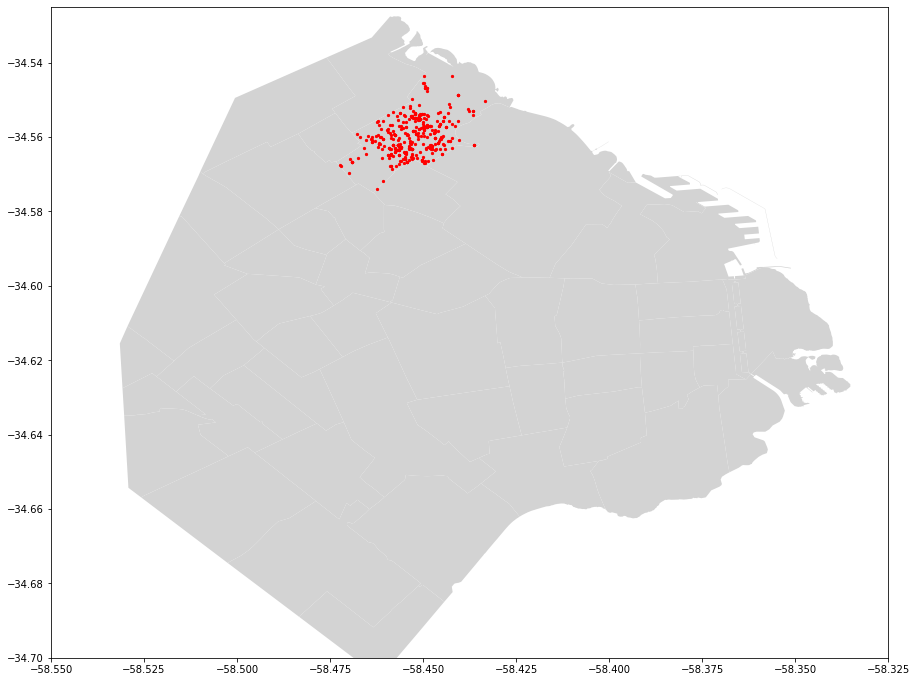

,arrive,search_method,leave,search_longitude,search_latitude,uid,timestamp,search_hour,arrive_hour,leave_hour,stay_time,geometry,weekday,reservas_barrio
20,2021-02-25 11:20:09,searchInThisArea,2021-02-25 12:20:09,-58.454943,-34.564354,None,2021-02-25 11:22:32,11.0,11,12,0 days 01:00:00,POINT (-58.45494 -34.56435),3,True
21,2020-09-17 10:45:00,update_time_home,2020-09-17 11:00:00,-58.451924,-34.559296,unauthenticated,2020-09-17 05:13:03,5.0,10,11,0 days 01:00:00,POINT (-58.45192 -34.55930),3,True
56,2021-02-20 21:53:44,searchInThisArea,2021-02-20 22:53:44,-58.459364,-34.564842,i5Wh05mUiYTcQtvyUaQ2Xj7y9Al1,2021-02-20 21:54:12,21.0,21,22,0 days 01:00:00,POINT (-58.45936 -34.56484),5,True
226,2021-02-23 18:25:31,searchInThisArea,2021-02-23 19:25:31,-58.454842,-34.565788,2Ds4tZNnQwNChuWnodJEDPBGDSy1,2021-02-23 18:26:18,18.0,18,19,0 days 01:00:00,POINT (-58.45484 -34.56579),1,True
263,2021-02-17 13:00:54,update_time_home,2021-02-17 14:00:54,-58.449352,-34.546752,unauthenticated,2021-02-17 12:55:30,12.0,13,14,0 days 01:00:00,POINT (-58.44935 -34.54675),2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19702,2021-02-23 18:27:01,google,2021-02-23 19:27:01,-58.454842,-34.565794,2Ds4tZNnQwNChuWnodJEDPBGDSy1,2021-02-23 18:27:34,18.0,18,19,0 days 01:00:00,POINT (-58.45484 -34.56579),1,True
19730,2021-03-25 09:30:24,google,2021-03-25 10:30:24,-58.456023,-34.562773,unauthenticated,2021-03-25 09:16:37,9.0,9,10,0 days 01:00:00,POINT (-58.45602 -34.56277),3,True
19733,2020-11-11 09:00:17,google,2020-11-11 10:00:17,-58.449675,-34.557740,unauthenticated,2020-11-11 08:47:49,8.0,9,10,0 days 01:00:00,POINT (-58.44967 -34.55774),2,True
19740,2021-02-13 14:27:03,searchInThisArea,2021-02-13 15:27:03,-58.449878,-34.557497,e8itgepSU1YX6Q48HtrDpz76OXr1,2021-02-13 14:28:17,14.0,14,15,0 days 01:00:00,POINT (-58.44988 -34.55750),5,True


In [48]:
search_neighborhood(neighborhood = 'belgrano', coordinates=data)

<AxesSubplot:xlabel='search_hour', ylabel='Count'>

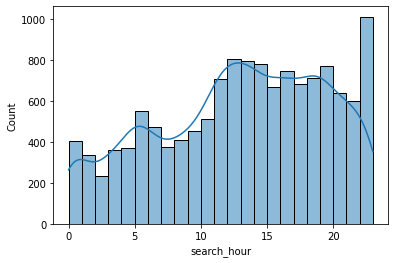

In [61]:
sns.histplot(data=data, x="search_hour", binwidth=1, kde=True)



<AxesSubplot:xlabel='arrive_hour', ylabel='Count'>

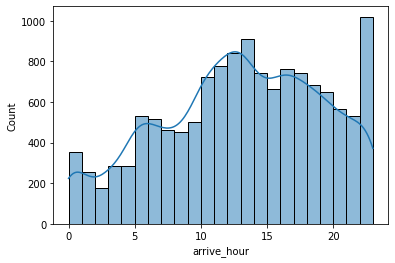

In [62]:
sns.histplot(data=data, x="arrive_hour", binwidth=1, kde=True)


<AxesSubplot:xlabel='arrive_hour', ylabel='Count'>

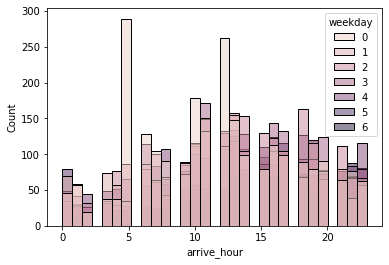

In [67]:
sns.histplot(data=data, x="arrive_hour", hue="weekday")


<AxesSubplot:xlabel='arrive_hour', ylabel='weekday'>

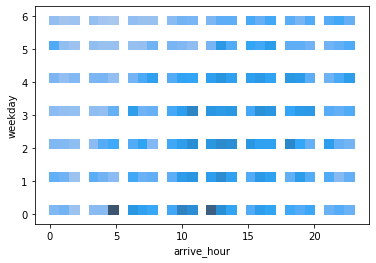

In [75]:
sns.histplot(data=data, x="arrive_hour", y="weekday", legend=True)